# Preprocessing and EDA

In [7]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE

## 1. Basic cleaning

In [2]:
# Read data frame
data = pd.read_csv('strokedata2.csv', encoding = 'utf-8')
data = data.drop('id', axis=1)  # drop id column

# Convert binary categorical variables to dummy variables
data = data[(data.gender=='Male')|(data.gender=='Female')] # drop obs where gender is other
data['gender'] = np.where(data['gender'] == 'Male', 1, 0)
data['ever_married'] = np.where(data['ever_married'] == 'Yes', 1, 0)
data['Residence_type'] = np.where(data['Residence_type'] == 'Urban', 1, 0)

data = data.reindex(columns=['stroke'] + list(data.columns[:-1]))  # Move stroke to first column

# Replace nan by string
data.loc[data.smoking_status.isnull(), 'smoking_status'] = 'Unknown'

# Rename column
data = data.rename({'Residence_type':'urban_home'}, axis=1)

# Rename values
data.work_type = data.work_type.map({'Private':'private', 'Self-employed': 'self_emp', 'children':'child', 'Never_worked':'never', 'Govt_job':'govt'})
data.smoking_status = data.smoking_status.map({'formerly smoked':'former', 'never smoked': 'never', 'smokes':'active', 'Unknown':'unknown'})

# Drop NAs
print('Dropping missing values:\n{}'.format(data.isnull().sum()[data.isnull().sum() > 0]))
data = data.dropna().reset_index(drop=True)
data.head(3)

Dropping missing values:
bmi    1458
dtype: int64


,stroke,gender,age,hypertension,heart_disease,ever_married,work_type,urban_home,avg_glucose_level,bmi,smoking_status
0,0,1,3.0,0,0,0,child,0,95.12,18.0,unknown
1,0,1,58.0,1,0,1,private,1,87.96,39.2,never
2,0,0,8.0,0,0,0,private,1,110.89,17.6,unknown


## 2. Prepare data for modelling

In [3]:
# One hot encode categorical variables
data_onehot = pd.get_dummies(data, columns=['work_type', 'smoking_status'])
data_onehot.to_csv('strokedata_onehot.csv', index=False)
data_onehot.head(3)

,stroke,gender,age,hypertension,heart_disease,ever_married,urban_home,avg_glucose_level,bmi,work_type_child,work_type_govt,work_type_never,work_type_private,work_type_self_emp,smoking_status_active,smoking_status_former,smoking_status_never,smoking_status_unknown
0,0,1,3.0,0,0,0,0,95.12,18.0,1,0,0,0,0,0,0,0,1
1,0,1,58.0,1,0,1,1,87.96,39.2,0,0,0,1,0,0,0,1,0
2,0,0,8.0,0,0,0,1,110.89,17.6,0,0,0,1,0,0,0,0,1


In [4]:
# Split data into train and test
train, test = train_test_split(data_onehot, test_size=0.2, random_state=42)

# Save train and test data
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [19]:
# SMOTE Oversampling
sm = BorderlineSMOTE(random_state=42)
X_train_os, y_train_os = sm.fit_resample(train.drop('stroke', axis=1), train.stroke)

# Save oversampled data
X_train_os.to_csv('X_train_SMOTE.csv', index=False)
y_train_os.to_csv('y_train_SMOTE.csv', index=False)

In [20]:
y_train_os.sum()/len(y_train_os)

0.5

## 3. Summary statistics and plots

In [16]:
sns.set(style="whitegrid")

# define variable types
cont_vars = data[['age', 'avg_glucose_level', 'bmi']]
binary_vars = data[['ever_married', 'urban_home', 'gender', 'hypertension', 'heart_disease']]
cat_vars = data[['smoking_status', 'work_type']]

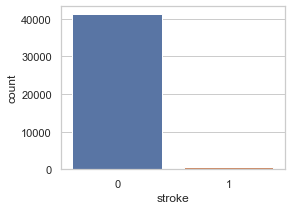

In [17]:
# Countplot of target variable
fig = plt.figure(figsize=(4,3))
sns.countplot(x='stroke', data=data)
plt.show()

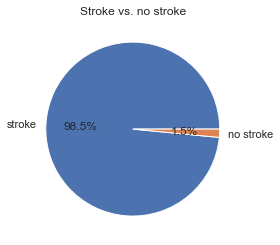

In [18]:
# Countplot of target variable
fig = plt.figure(figsize=(5,4))
plt.pie(x=data.stroke.value_counts(), labels=['stroke', 'no stroke'], autopct='%1.1f%%')
plt.title('Stroke vs. no stroke')
plt.show()

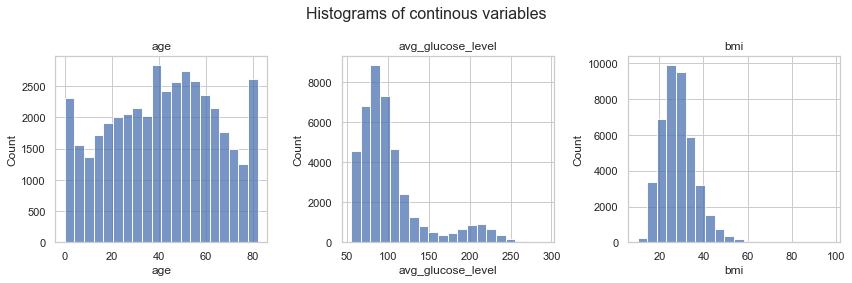

In [19]:
# plot histogram of all continous columns
fig, axs = plt.subplots(1, 3, figsize=(12,4))
for i, col in enumerate(cont_vars.columns):
    sns.histplot(ax=axs[i], x=col, data=data, bins=20)
    axs[i].set_title(col)
fig.suptitle('Histograms of continous variables', fontsize=16)
plt.tight_layout()
plt.show()

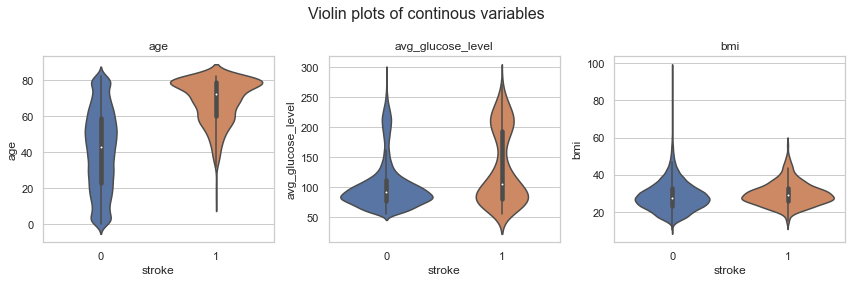

In [20]:
# plot boxplot of all continous columns
fig, axs = plt.subplots(1, 3, figsize=(12,4))
for i, col in enumerate(cont_vars.columns):
    sns.violinplot(ax=axs[i], y=col, x='stroke', data=data)
    axs[i].set_title(col)
fig.suptitle('Violin plots of continous variables', fontsize=16)
plt.tight_layout()
plt.show()

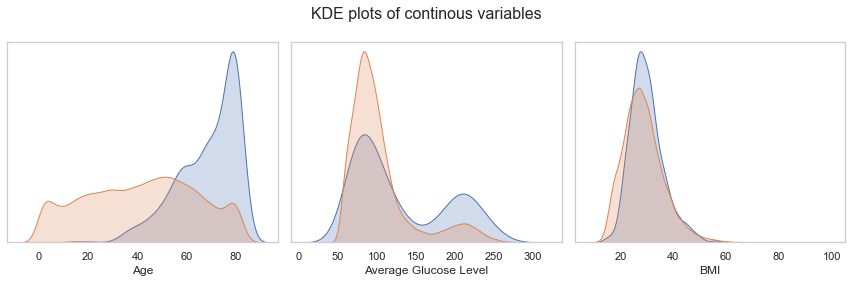

In [21]:
# plot boxplot of all continous columns
data_stroke = data[data['stroke'] == 1]
data_nostroke = data[data['stroke'] == 0]
names = ['Age', 'Average Glucose Level', 'BMI']

fig, axs = plt.subplots(1, 3, figsize=(12,4))
for i, col in enumerate(cont_vars.columns):
    sns.kdeplot(ax=axs[i], x=col, shade=True, data=data_stroke)
    sns.kdeplot(ax=axs[i], x=col, shade=True, data=data_nostroke)
    axs[i].set_ylabel('')
    axs[i].set_yticks([])
    axs[i].set_xlabel(names[i])
    axs[i].grid(False)
fig.suptitle('KDE plots of continous variables', fontsize=16)
plt.tight_layout()
plt.show()

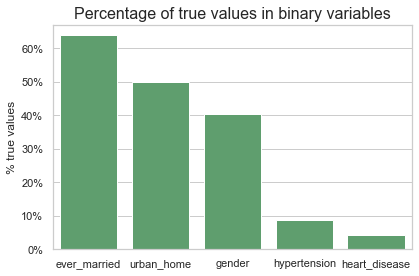

In [22]:
binary_perc = binary_vars.sum()/len(binary_vars)*100
sns.barplot(x=binary_perc.index, y=binary_perc, color='g')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:}%'.format(int(y))))
plt.ylabel('% true values')
plt.title('Percentage of true values in binary variables', fontsize=16)
plt.tight_layout()
plt.show()

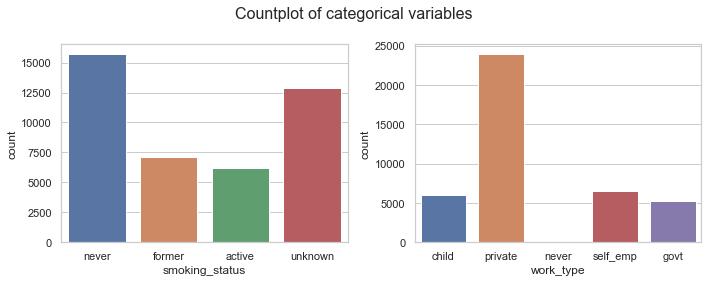

In [23]:
# plot barplot of all categorical columns
fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x='smoking_status', data=cat_vars, ax=axs[0], order=['never', 'former', 'active', 'unknown'])
sns.countplot(x='work_type', data=cat_vars, ax=axs[1])
fig.suptitle('Countplot of categorical variables', fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\stefan\AppData\Local\Temp/ipykernel_7372/4672858.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


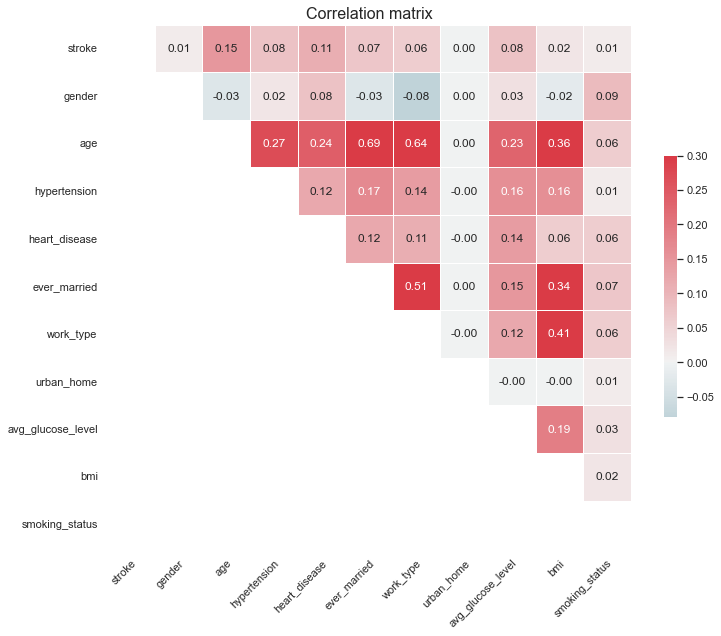

In [24]:
# Create numeric correlation matrix
corr_data = data.copy()
corr_data.smoking_status = corr_data.smoking_status.map(  # quantize smoking status
    {'never': 0, 'former': 1, 'active': 2, 'unknown': np.nan})
corr_data.work_type = corr_data.work_type.map(  # quantize work type
    {'child': 0, 'never': 1, 'govt': 2, 'private': 3, 'self_emp': 4})
corr = corr_data.corr().round(2)

# Generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Plot as heatmap
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title('Correlation matrix', fontsize=16)
plt.tight_layout()
plt.show()